In [24]:
import re
import time
import json
import numpy as np
import pandas as pd
from langchain.vectorstores import Chroma
from langchain.chat_models import ChatOpenAI
from langchain.chains import QAGenerationChain
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain.llms import OpenAI
from langchain.vectorstores import Chroma
from langchain.vectorstores import FAISS
from langchain.chains import VectorDBQA
from langchain.evaluation.qa import QAEvalChain

In [2]:
# Read
episode_id = "0333"
doc = pd.read_csv("audio_transcription/%s.txt"%episode_id,sep='\t')
doc.columns=['links','time','chunks']

# Clean text chunks 
doc['clean_chunks']=doc['chunks'].astype(str).apply(lambda x: x.strip())

# Write updated file (b/c we isolate sections for question-answer formulation below)
with open('audio_transcription/%s_text.txt'%episode_id, "w") as f:
    for i in doc.index:
        string = doc.loc[i,'clean_chunks']
        f.write(string + "\n") 

In [4]:
# Note: feeding complete file failed for non-obvious reasons (JSON error; searched at length for invalid chars but could not find)
# In any case, I fed small chunks of the dataset into the QA generation and it worked (and maybe improved the QA since inputs were selected 
filename = 'audio_transcription/0333_text_transformer.txt'
loader = TextLoader(filename)
doc_karpathy = loader.load()[0]
txt_transformer = doc_karpathy.page_content

filename = 'audio_transcription/0333_text_sw2dot0.txt'
loader = TextLoader(filename)
doc_karpathy = loader.load()[0]
txt_sw20 = doc_karpathy.page_content

filename = 'audio_transcription/0333_text_sd.txt'
loader = TextLoader(filename)
doc_karpathy = loader.load()[0]
txt_sd= doc_karpathy.page_content

chain = QAGenerationChain.from_llm(ChatOpenAI(temperature = 0))
qa_karpathy_transformer = chain.run(txt_transformer)

chain = QAGenerationChain.from_llm(ChatOpenAI(temperature = 0))
qa_karpathy_sw20 = chain.run(txt_sw20)

chain = QAGenerationChain.from_llm(ChatOpenAI(temperature = 0))
qa_karpathy_sd= chain.run(txt_sd)

qa_all = qa_karpathy_transformer + qa_karpathy_sw20 + qa_karpathy_sd
qa_all

[{'question': 'What is the transformer architecture in deep learning?',
  'answer': 'The transformer architecture is a neural network architecture that is general purpose and can process different sensory modalities like vision, audio, text, and video. It is simultaneously expressive in the forward pass, optimizable via backpropagation, gradient descent, and efficient high parallelism compute graph.'},
 {'question': 'What is a transformer and how is it designed?',
  'answer': 'A transformer is a series of blocks with attention and a multilayer perceptron. It is designed to be very expressive in a forward pass, optimizable in a backward pass, and efficient in hardware. The residual connections support the ability to learn short algorithms fast and first, and then gradually extend them longer during training.'},
 {'question': 'What is a transformer architecture and why is it important?',
  'answer': 'A transformer architecture is a type of neural network that is remarkably resilient and 

`Llama-Index`

https://colab.research.google.com/drive/1uL1TdMbR4kqa0Ksrd_Of_jWSxWt1ia7o?usp=sharing#scrollTo=3a5cb155-cfe0-4c89-a2b4-c61d5b7cbe61


https://gpt-index.readthedocs.io/en/latest/guides/usage_pattern.html

* chunk_size_limit (Optional[int]) – Optional chunk size limit. If not provided, will use the default chunk size limit (4096 max input size).

`Eval`
https://langchain.readthedocs.io/en/latest/use_cases/evaluation/qa_generation.html

In [10]:
from llama_index import download_loader, GPTSimpleVectorIndex
from llama_index import Document
from llama_index import LLMPredictor

llm_predictor = LLMPredictor(llm=ChatOpenAI(temperature=0, max_tokens=512))
text_list = list(doc['clean_chunks'])
documents = [Document(t) for t in text_list]
llama_ix_512 = GPTSimpleVectorIndex(documents,chunk_size_limit=512,llm_predictor=llm_predictor)
llama_ix = GPTSimpleVectorIndex(documents,llm_predictor=llm_predictor)


INFO:llama_index.token_counter.token_counter:> [build_index_from_documents] Total LLM token usage: 0 tokens
INFO:llama_index.token_counter.token_counter:> [build_index_from_documents] Total embedding token usage: 48505 tokens
INFO:llama_index.token_counter.token_counter:> [build_index_from_documents] Total LLM token usage: 0 tokens
INFO:llama_index.token_counter.token_counter:> [build_index_from_documents] Total embedding token usage: 48505 tokens


In [11]:
def make_splits(chunk_size,overlap,texts,links,episode_id):

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap) 
    splits = text_splitter.split_text(texts)
    bins = np.linspace(0,len(links)-1,len(splits),dtype=int)
    sampled_links = [links[i] for i in bins]
    metadatas=[{"source":link,"id":episode_id,"link":link} for link in sampled_links]
    db = FAISS.from_texts(splits, OpenAIEmbeddings(), metadatas=metadatas) 
    chain = VectorDBQA.from_chain_type(llm=ChatOpenAI(temperature=0), 
                                       chain_type="stuff", 
                                       vectorstore=db, 
                                       input_key="question")
    
    return chain 

episode_id = "0333"
doc = pd.read_csv("audio_transcription/%s.txt"%episode_id,sep='\t')
doc.columns=['links','time','chunks']
doc['clean_chunks']=doc['chunks'].astype(str).apply(lambda x: x.strip())

chains = {}
overlap = 50
for chunk_size in [250,500,1000,2000,3000]:
    chain = make_splits(chunk_size,overlap,list(doc['clean_chunks']),list(doc['links']),episode_id)
    chains[chunk_size] = chain


INFO:faiss.loader:Loading faiss.
INFO:faiss.loader:Successfully loaded faiss.


In [25]:
def run_eval(chain,ix_type):
    predictions = []
    predicted_dataset = []
    for data in qa_all:
        start_time = time.time()
        new_data = {"question": data["question"],"answer": data["answer"]}
        if ix_type == "langchain":
            predictions.append(chain(new_data))
            predicted_dataset.append(new_data)
        elif ix_type == "llama":
            print(new_data["question"])
            print(chain.query(new_data["question"]).response)
            predictions.append({"result":chain.query(new_data["question"]).response})
            predicted_dataset.append(new_data)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time} seconds")
        print("--------")
    return predictions,predicted_dataset

predictions_list = []
scores_list = []
eval_chain = QAEvalChain.from_llm(llm=ChatOpenAI(temperature=0))

for chunk_size in [250,500,1000,2000,3000]:
    predictions,predicted_dataset=run_eval(chains[chunk_size],"langchain")
    predictions_list.append(predictions)
    graded_outputs = eval_chain.evaluate(predicted_dataset, predictions, question_key="question", prediction_key="result")
    scores_list.append(graded_outputs)

for ix in [llama_ix_512,llama_ix]:
    predictions,predicted_dataset=run_eval(ix,"llama")
    predictions_list.append(predictions)
    graded_outputs = eval_chain.evaluate(predicted_dataset, predictions, question_key="question", prediction_key="result")
    scores_list.append(graded_outputs)

print(scores_list)

Elapsed time: 725.9269256591797 seconds
--------
Elapsed time: 3.88500714302063 seconds
--------
Elapsed time: 3.8118197917938232 seconds
--------


Elapsed time: 11818.47865486145 seconds
--------
Elapsed time: 3.0771851539611816 seconds
--------
Elapsed time: 3.8846051692962646 seconds
--------
Elapsed time: 2.6876630783081055 seconds
--------


Elapsed time: 12272.676991939545 seconds
--------
Elapsed time: 5.000528812408447 seconds
--------
Elapsed time: 4.8211870193481445 seconds
--------
Elapsed time: 4.371562957763672 seconds
--------
Elapsed time: 5.219797134399414 seconds
--------
Elapsed time: 4.601593017578125 seconds
--------
Elapsed time: 1.9504101276397705 seconds
--------
Elapsed time: 5.928202152252197 seconds
--------


Elapsed time: 6290.852502822876 seconds
--------
Elapsed time: 5.34326696395874 seconds
--------
Elapsed time: 4.804105997085571 seconds
--------
Elapsed time: 3.5940332412719727 seconds
--------
Elapsed time: 4.095090866088867 seconds
--------
Elapsed time: 2.1014280319213867 seconds
--------
Elapsed time: 5.776889085769653 seconds
--------
Elapsed time: 6.121999025344849 seconds
--------
Elapsed time: 5.7978010177612305 seconds
--------
Elapsed time: 6.471468925476074 seconds
--------
Elapsed time: 7.53118896484375 seconds
--------
Elapsed time: 5.115376949310303 seconds
--------
Elapsed time: 2.8032829761505127 seconds
--------
Elapsed time: 6.145335912704468 seconds
--------
Elapsed time: 6.848323106765747 seconds
--------
Elapsed time: 8.173394918441772 seconds
--------
Elapsed time: 5.457597970962524 seconds
--------
Elapsed time: 6.666595220565796 seconds
--------
Elapsed time: 5.057386875152588 seconds
--------
Elapsed time: 1.9936869144439697 seconds
--------
What is the trans

INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 54 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 9 tokens


The transformer architecture is a type of architecture used in deep learning.


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 54 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 9 tokens


Elapsed time: 5.529140949249268 seconds
--------
What is a transformer and how is it designed?


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 65 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 10 tokens


A transformer is a type of architecture, but without further information it is unclear what type of architecture it refers to.


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 65 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 10 tokens


Elapsed time: 5.831722974777222 seconds
--------
What is a transformer architecture and why is it important?


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 103 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 11 tokens


A transformer architecture is a type of neural network architecture used in natural language processing tasks. It is important because it allows for efficient processing of sequential data, such as text, by attending to the relevant parts of the input sequence. This has led to significant improvements in language modeling and other NLP tasks.


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 103 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 11 tokens


Elapsed time: 9.424509763717651 seconds
--------
What is a language model and how does it work?


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 112 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 11 tokens


A language model is a computational model that is designed to predict the probability of a sequence of words in a given language. It works by analyzing large amounts of text data and learning the patterns and relationships between words. This allows the model to generate new sentences or predict the likelihood of a particular sentence being grammatically correct and semantically meaningful.


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 112 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 11 tokens


Elapsed time: 9.728826999664307 seconds
--------
What is the author's opinion on the transition to software 2.0?


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 84 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 15 tokens


There is no clear indication of the author's opinion on the transition to software 2.0.


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 84 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 15 tokens


Elapsed time: 5.733378171920776 seconds
--------
What is the task of programming in software 2.0?


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 97 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 12 tokens


The question is asking for an opinion on the task of programming in software 2.0. It does not provide a clear answer or definition of what software 2.0 is.


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 97 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 12 tokens


Elapsed time: 7.20390510559082 seconds
--------
What are the three properties of a good dataset for supervised learning?


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 99 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 13 tokens


There are no specific three properties mentioned in the given context information. However, it is implied that a good dataset for supervised learning should include input data, desired output data, and sufficient quantity and quality of data.


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 99 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 13 tokens


Elapsed time: 7.513329267501831 seconds
--------
What is the transformer architecture in deep learning?


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 54 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 9 tokens


The transformer architecture is a type of architecture used in deep learning.


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 54 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 9 tokens


Elapsed time: 5.20123815536499 seconds
--------
What is a transformer and how is it designed?


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 65 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 10 tokens


A transformer is a type of architecture, but without further information it is unclear what type of architecture it refers to.


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 65 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 10 tokens


Elapsed time: 6.196987867355347 seconds
--------
What is a transformer architecture and why is it important?


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 107 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 11 tokens


A transformer architecture is a type of neural network architecture used in natural language processing tasks. It is important because it allows for efficient processing of sequential data, such as text, by attending to the relevant parts of the input sequence. This has led to significant improvements in language modeling, machine translation, and other NLP tasks.


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 107 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 11 tokens


Elapsed time: 9.511483192443848 seconds
--------
What is a language model and how does it work?


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 114 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 11 tokens


A language model is a type of artificial intelligence that is designed to predict the likelihood of a sequence of words in a given language. It works by analyzing large amounts of text data and using statistical methods to identify patterns and relationships between words. The model then uses this information to generate new text that is similar in style and content to the original data.


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 112 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 11 tokens


Elapsed time: 9.832738161087036 seconds
--------
What is the author's opinion on the transition to software 2.0?


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 84 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 15 tokens


There is no clear indication of the author's opinion on the transition to software 2.0.


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 84 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 15 tokens


Elapsed time: 5.865574836730957 seconds
--------
What is the task of programming in software 2.0?


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 88 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 12 tokens


The question is asking for an opinion on the task of programming in software 2.0. It does not provide a definitive answer.


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 97 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 12 tokens


Elapsed time: 6.613225936889648 seconds
--------
What are the three properties of a good dataset for supervised learning?


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 99 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 13 tokens


There are no specific three properties mentioned in the given context information. However, it is implied that a good dataset for supervised learning should include input data, desired output data, and sufficient quantity and quality of data.


INFO:llama_index.token_counter.token_counter:> [query] Total LLM token usage: 99 tokens
INFO:llama_index.token_counter.token_counter:> [query] Total embedding token usage: 13 tokens


Elapsed time: 7.5888872146606445 seconds
--------
[[{'text': 'INCORRECT'}, {'text': 'INCORRECT'}, {'text': 'CORRECT'}, {'text': 'CORRECT'}, {'text': 'INCORRECT'}, {'text': 'INCORRECT'}, {'text': 'INCORRECT'}], [{'text': 'CORRECT'}, {'text': 'INCORRECT'}, {'text': 'CORRECT'}, {'text': 'CORRECT'}, {'text': 'INCORRECT'}, {'text': 'CORRECT'}, {'text': 'CORRECT'}], [{'text': 'CORRECT'}, {'text': 'INCORRECT'}, {'text': 'CORRECT'}, {'text': 'CORRECT'}, {'text': 'CORRECT'}, {'text': 'CORRECT'}, {'text': 'CORRECT'}], [{'text': "PARTIALLY CORRECT. The student's answer accurately describes some aspects of the transformer architecture, such as its general-purpose nature, message passing scheme, and use in various tasks. However, it incorrectly states that the transformer architecture is designed to be optimizable via gradient descent and efficient in hardware, which are not unique to this architecture. Additionally, the true answer specifies that the transformer architecture can process different 

In [19]:
for p in predictions_list:
    for q in 
predictions_list[0]

[Response(response='\n\nThe transformer architecture is a type of architecture used in deep learning.', source_nodes=[SourceNode(source_text='the transformer architecture.', doc_id='8e06f2f8-4696-4a16-aaaa-d05820a044cd', extra_info=None, node_info={'start': 0, 'end': 29}, similarity=0.9112588378605513, image=None)], extra_info=None),
 Response(response='\n\nA transformer is a type of architecture, but without further information it is unclear what type of architecture it refers to.', source_nodes=[SourceNode(source_text='the transformer architecture.', doc_id='8e06f2f8-4696-4a16-aaaa-d05820a044cd', extra_info=None, node_info={'start': 0, 'end': 29}, similarity=0.8776223552817073, image=None)], extra_info=None),
 Response(response='\n\nA transformer architecture is a type of neural network architecture used in natural language processing tasks. It is important because it allows for efficient processing of sequential data, such as text, by attending to the relevant parts of the input seq

In [26]:
stor=pd.DataFrame()
for i,chunk_size in enumerate([250,500,1000,2000,3000,'llama_ix_512','llama_ix']):
    d=scores_list[i]
    incorrect_counts = []
    for dictionary in d:
        if dictionary['text'] == 'INCORRECT':
            incorrect_counts.append(1)
        else:
            incorrect_counts.append(0)
    stor.loc[chunk_size,'num_incorrect']=sum(incorrect_counts)

In [27]:
stor['pct_incorrect'] = stor['num_incorrect'] / 7

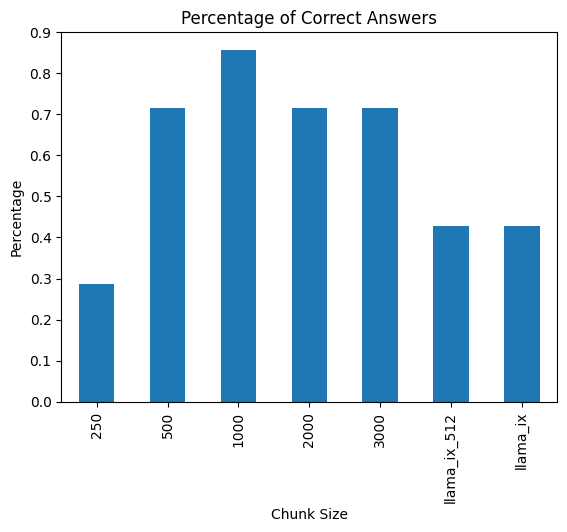

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
stor['pct_correct'] = 1 - stor['pct_incorrect']
stor['pct_correct'].plot(kind='bar')
plt.title('Percentage of Correct Answers')
plt.xlabel('Chunk Size')
plt.ylabel('Percentage')
plt.show()

In [29]:
stor

,num_incorrect,pct_incorrect,pct_correct
250,5.0,0.714286,0.285714
500,2.0,0.285714,0.714286
1000,1.0,0.142857,0.857143
2000,2.0,0.285714,0.714286
3000,2.0,0.285714,0.714286
llama_ix_512,4.0,0.571429,0.428571
llama_ix,4.0,0.571429,0.428571
